In [2]:
import geopandas as gpd
from matplotlib import pyplot as plt

In [3]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
tiles_df = gpd.read_file('output/covering_tiles.kml', driver='KML')
print(repr(tiles_df.crs))
print(tiles_df)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

     Name Description                                           geometry
0                      POLYGON Z ((-120.28118 48.72093 0.00000, -118....
1                      POLYGON Z ((-119.67207 47.82260 0.00000, -118....
2                      POLYGON Z ((-119.71936 48.72091 0.00000, -118....
3                      POLYGON Z ((-113.43120 42.42690 0.00000, -112....
4                      POLYGON Z ((-112.21648 42.44624 0.00000, -110....
...   ...         ...                                                ...
1179                   POLYGON Z ((29.99818 -26.18805 0.00000, 31.096...
1180                   POLYGON Z ((136.08714 -34.33630 0.00000, 137.2...
1181                   POLYGON Z 

Average time: 0.07087321281433105


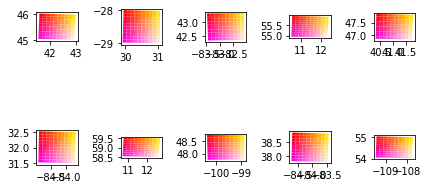

In [197]:
import shapely.ops as shops
import shapely.geometry as shgeom
import shapely.affinity as shaff
import time


ax = None
def plot_geom(geom, **kwargs):
    """
    Plot geom on the global axis.
    """
    assert ax is not None
    gpd.GeoSeries(geom).plot(ax=ax, **kwargs)

def split_1d(geom, n, direction, debug=False):
    """
    Split geom n times in a given direction.
    Return the splitted geometries.
    Follows method in https://stackoverflow.com/q/58283684.

    Given this square:
    1 --> 2
    ^     |
    |     v
    0 <-- 3

    left -> right: lerp 0, 1 -> 3, 2
    top -> down: lerp 1, 2 -> 0, 3
    """
    coords = list(shgeom.Point(c) for c in geom.exterior.coords)
    if len(coords) == 5:
        for i, c in enumerate(coords):
            if i == len(coords)-1:
                d = coords[0]
            else:
                d = coords[i+1]
            if c == d:
                if debug: print('Remove', i)
                del coords[i]
                break
    assert len(coords) == 4

    # rotate linear ring so that coords[0] is the bottom left
    # assumes geometry only has one point in quadrant III
    def offset_from_centroid(geom, c):
        return shaff.translate(c, -geom.centroid.x, -geom.centroid.y)
    min_coord_i = 0
    for i, c in enumerate(coords):
        off = offset_from_centroid(geom, c)
        if off.x < 0 and off.y < 0:
            min_coord_i = i
            if debug: print('Rotate', i, 'to first index')
    coords = coords[min_coord_i:] + coords[:min_coord_i]

    # Assume the following:
    # 1. 4 coordinates are the 4 bounds of the rectangle
    # 2. Coordinates are in a linear ring
    # 3. Bottom left coordinate is at coords[0]

    if debug:
        # plot linear ring
        for i, c in enumerate(coords):
            plot_geom(c, color=(0, 0, 1, (i+1)/len(coords)))

    # lerp from a to b, n times
    splitters = []
    if direction == 'left_right':
        ls_a = shgeom.LineString((coords[0], coords[3]))
        ls_b = shgeom.LineString((coords[1], coords[2]))
    elif direction == 'top_down':
        ls_a = shgeom.LineString((coords[1], coords[0]))
        ls_b = shgeom.LineString((coords[2], coords[3]))
    else:
        raise NotImplementedError(direction)
    # test that top and bot are correctly named
    if debug:
        plot_geom(ls_a, color='red')
        plot_geom(ls_b, color='green')
    
    extend_percent = 0.2  # how much to extend the line
    for i in range(1, n):
        # lerp along the line
        lerp_percent = i / n
        interp_a_ls = ls_a.interpolate(lerp_percent, normalized=True)
        interp_b_ls = ls_b.interpolate(lerp_percent, normalized=True)

        # extend the line by a portion to account for floating point precision
        new_interp_a_ls = shgeom.Point(
            (interp_a_ls.x - ((interp_b_ls.x - interp_a_ls.x) * extend_percent)),
            (interp_a_ls.y - ((interp_b_ls.y - interp_a_ls.y) * extend_percent))
            )
        new_interp_b_ls = shgeom.Point(
            (interp_b_ls.x - ((interp_a_ls.x - interp_b_ls.x) * extend_percent)),
            (interp_b_ls.y - ((interp_a_ls.y - interp_b_ls.y) * extend_percent))
            )
        if debug:
            plot_geom(new_interp_a_ls, color=(1, 0, 0, lerp_percent))
            plot_geom(new_interp_b_ls, color=(0, 1, 0, lerp_percent))
        
        # create a new LineString which will split geom
        split_ls = shgeom.LineString((new_interp_b_ls, new_interp_a_ls))
        splitters.append(split_ls)

    # split geom using all the splitters.
    # this assumes ordering of the splitters (left -> right, up -> down)...
    # and will fail if the ordering is messed up
    splits = []
    q = geom
    for i, splitter in enumerate(splitters):
        if debug:
            plot_geom(q, color=(0, 0, 0, 0), edgecolor=(0, 0, 1), hatch='o')
            plot_geom(splitter, color=(0, 0, 1))
        split_result = shops.split(q, splitter)
        if len(split_result) == 2:
            p, q = split_result
            splits.append(p)
        else:
            # the geometry was not split by the splitter, blurt diagnostics
            if splitter.intersects(q):
                print('line intersects but does not split')
            else:
                print('line does not intersect')
            raise Exception(f'iteration {i} {len(split_result)=}')
    splits.append(q)
    return splits


times = []
n = 10
fig, axs = plt.subplots(2, 5)
axs = axs.flatten()
for tile_i, tile_geom in enumerate(tiles_df.geometry.sample(10)):
    # can't be assed to axis-align the box, so just do two separate lerps
    small_tiles = []  # results of splitting, in a 1d array
    begin = time.time()
    splits = split_1d(tile_geom, n, 'left_right')
    for i, s in enumerate(splits):
        s_split = split_1d(s, n, 'top_down')
        small_tiles += s_split
    end = time.time()
    times.append(end-begin)
    
    # plot the results
    ax = axs[tile_i]
    for i in range(n):
        for j in range(n):
            plot_geom(small_tiles[i*n+j], color=(1, i/n, j/n))
fig.tight_layout()
print('Average time:', sum(times)/len(times))